<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 一幅图有很多局部极大值，如何 argmax 得到坐标？
* 两个相距很近的高斯，中间会不会鼓起来，比两边的峰值还高？如何 argmax 找到两边峰值的位置，而不是中间鼓包的位置？
* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.
* 把图片大小改为 256*256

# 1. Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['DataPreprocessing.ipynb',
 'Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap.ipynb']

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb

import warnings
warnings.filterwarnings('ignore')


In [3]:
from utils.network import *

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2. Data Preparation

In [5]:
train_size = 200
test_size = 200

In [6]:
with open("datasets/cropped_helen/helen_cropped_train_pts.json",'r') as htrain:
  htrain_pts = json.load(htrain)
with open("datasets/cropped_helen/helen_cropped_test_pts.json",'r') as htest:
  htest_pts = json.load(htest)

In [7]:
# Load pictures
train_tensor = torch.zeros((train_size,3,224,224))
train_label = torch.zeros((train_size,68,2))
i=0
for train_key in htrain_pts.keys():
  path = os.path.join("datasets/cropped_helen/trainset", train_key + '.jpg')
  pic = cv2.imread(path)
  pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
  train_tensor[i,:,:,:] = torch.from_numpy(pic).permute(2,0,1)

  train_label[i,:,:] = torch.Tensor(htrain_pts[train_key])

  if (i+1)%40 == 0:
    print('Caught [%d/%d] pictures......' %(i+1,train_size))

  if i == train_size-1:
    break
  else: i+=1
train_tensor = train_tensor.to(device)
train_label = train_label.reshape(train_size,-1)
train_label[:,1::2] = 224 - train_label[:,1::2]
train_label = train_label.to(device)

Caught [40/200] pictures......
Caught [80/200] pictures......
Caught [120/200] pictures......
Caught [160/200] pictures......
Caught [200/200] pictures......


In [8]:
# Load pictures
test_tensor = torch.zeros((test_size,3,224,224))
test_label = torch.zeros((test_size,68,2))
i=0
for test_key in htest_pts.keys():
  path = os.path.join("datasets/cropped_helen/testset", test_key + '.jpg')
  pic = cv2.imread(path)
  pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
  test_tensor[i,:,:,:] = torch.from_numpy(pic).permute(2,0,1)

  test_label[i,:,:] = torch.Tensor(htest_pts[test_key])

  if (i+1)%40 == 0:
    print('Caught [%d/%d] pictures......' %(i+1,test_size))

  if i == test_size-1:
    break
  else: i+=1
test_label = test_label.reshape(test_size,-1)
test_label[:,1::2] = 224-test_label[:,1::2]

Caught [40/200] pictures......
Caught [80/200] pictures......
Caught [120/200] pictures......
Caught [160/200] pictures......
Caught [200/200] pictures......


# 3. Make Heatmap Label

In [9]:
def get_heatmap(label, var):
  ########
  ## label(200,136) var:scalar
  ########
  N = label.shape[0]
  npts = int(label.shape[1]/2)
  gaussian_map = torch.zeros((N,224,224))

  large_gaussian = torch.zeros((501,501))
  for i in range(501):
    for j in range(501):
      numb = torch.tensor(((i-250)**2+(j-250)**2)/2/(var**2))
      large_gaussian[i,j] = torch.exp(-numb)

  for n in range(N):
    for p in range(npts):
      x = int(label[n,2*p])
      y = int(label[n,2*p+1])
      gaussian_map[n,:,:] += large_gaussian[250-x:474-x,250-y:474-y]


  gaussian_map[gaussian_map<0.01] = 0

  return gaussian_map


In [10]:
var = 3
train_heatmap = get_heatmap(train_label,var).to(device)
#test_heatmap = get_heatmap(test_label,var).to(device)

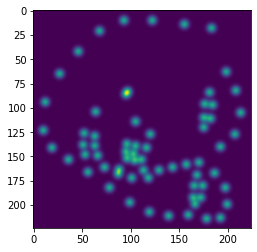

In [11]:
plt.imshow(train_heatmap[0,:,:].cpu())

This picture seems rotated because x and y axis are different between `plt.imshow` and `torch.tensor`.

# 4. Heatmap Regression

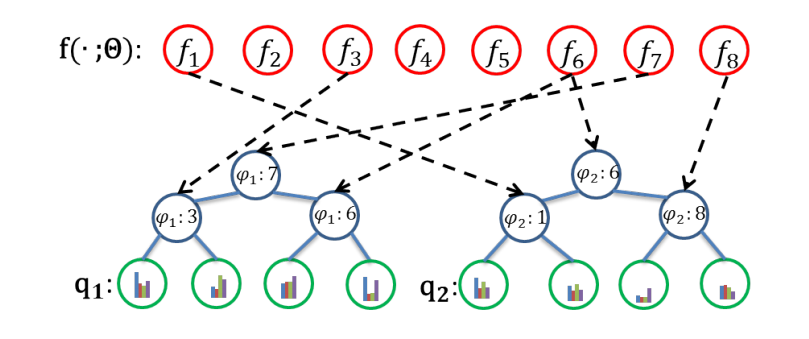

In [12]:
def phi(cnn_fc):
  device = cnn_fc.device
  N,C = cnn_fc.shape
  out = torch.zeros(N,C).to(device)

  phi1l = cnn_fc[:,2]*torch.sigmoid(cnn_fc[:,6])
  phi1r = cnn_fc[:,5]*(1-torch.sigmoid(cnn_fc[:,6]))
  phi2l = cnn_fc[:,0]*torch.sigmoid(cnn_fc[:,5])
  phi2r = cnn_fc[:,7]*(1-torch.sigmoid(cnn_fc[:,5]))

  out[:,0] = torch.sigmoid(phi1l)
  out[:,1] = 1-torch.sigmoid(phi1l)
  out[:,2] = torch.sigmoid(phi1r)
  out[:,3] = 1-torch.sigmoid(phi1r)
  out[:,4] = torch.sigmoid(phi2l)
  out[:,5] = 1-torch.sigmoid(phi2l)
  out[:,6] = torch.sigmoid(phi2r)
  out[:,7] = 1-torch.sigmoid(phi2r)

  return out

In [13]:
def train_ld(gt_label, prob, leaf_q):
  # gt_label(200,224*224) prob(200,8) leaf_q(8,224*224)
  device = prob.device
  new_q = torch.zeros(leaf_q.shape).to(device)
  L = prob.shape[1]

  gamma = torch.unsqueeze(prob,2)*torch.unsqueeze(leaf_q,0) # (200,8,224*224)
  gamma = gamma/torch.sum(gamma,axis=2,keepdims=True)

  score = torch.zeros(gamma.shape).to(device)
  for l in range(L):
    score[:,l,:] = gt_label*gamma[:,l,:]
  score = torch.sum(score,axis=0) # (8,224*224)
  #new_q[l,:] = score/torch.sum(score)

  return score/torch.sum(score,axis=1,keepdims=True)

In [14]:
#######################
# Initialization
Total_train = 10

# RF initialization
rf_iters = 1000

# CNN initilization
heatmap_train_label = train_heatmap.reshape(train_size,-1)
heatmap_train_label = heatmap_train_label/torch.sum(heatmap_train_label,axis=1,keepdims=True)

learning_rate = 3e-4
criterion = nn.L1Loss()

num_epochs = 500
heatmap_cnn = CNN_module().to(device)
optimizer = torch.optim.Adam(heatmap_cnn.parameters(),lr=learning_rate)

In [15]:
cnn_loss_hist = torch.zeros(num_epochs)
for round in range(Total_train):
  # break_or_not = False
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  

  # Train Regression Trees
  if round == 0:
    leaf_q = torch.ones(8,224*224).to(device)/(224*224)
    cnn_prob = torch.ones(train_size,8).to(device)/8
  
  # for nrf in range(rf_iters):
  #   leaf_q = train_ld(heatmap_train_label, cnn_prob, leaf_q)

  #   if (nrf+1)%20 == 0 or nrf == 0:
  #     diff = torch.matmul(cnn_prob,leaf_q)-heatmap_train_label
  #     loss = torch.sum(diff**2)
  #     print("     RF training [%d/%d], loss: %.4f" %(nrf+1, rf_iters, loss))
  with torch.no_grad():
    loss0 = torch.sum((torch.matmul(cnn_prob,leaf_q)-heatmap_train_label)**2)
    leaf_q = torch.matmul(torch.linalg.pinv(cnn_prob), heatmap_train_label)
    loss1 = torch.sum((torch.matmul(cnn_prob,leaf_q)-heatmap_train_label)**2)
    print("     RF training loss: %.4f -> %.4f" %(loss0, loss1))


  # Train CNN
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = heatmap_cnn(train_tensor) #(200,8)
    cnn_prob = phi(outputs)
  
    # Points predicted by CNN
    pred_value = torch.matmul(cnn_prob, leaf_q)
    pred_value = pred_value/torch.sum(pred_value,axis=1,keepdims=True)
    loss = criterion(pred_value, heatmap_train_label)
    cnn_loss_hist[epoch] = loss.item()
    loss.backward(retain_graph=True)
    optimizer.step()
    if (epoch+1) % 100 == 0 or epoch == 0:
      print('    CNN: Epoch [%d/%d], Loss: %.8f' %(epoch+1, num_epochs, loss.item()*train_size))

  #   if loss.item()*train_size < 7e-7:
  #     print("Converged")
  #     break_or_not = True
  #     break
  # if break_or_not == True:
  #   break

###########################################################
Round 1, Using GPU
     RF training loss: 0.0274 -> 0.0270
    CNN: Epoch [1/500], Loss: 473.42109680
    CNN: Epoch [100/500], Loss: 48.72005582
    CNN: Epoch [200/500], Loss: 21.96834683
    CNN: Epoch [300/500], Loss: 48.47651124
    CNN: Epoch [400/500], Loss: 22.77881354
    CNN: Epoch [500/500], Loss: 8.59365687
###########################################################
Round 2, Using GPU
     RF training loss: 1521741.6250 -> 0.0318
    CNN: Epoch [1/500], Loss: 0.00745350
    CNN: Epoch [100/500], Loss: 0.01441872
    CNN: Epoch [200/500], Loss: 0.01415356
    CNN: Epoch [300/500], Loss: 0.01383858
    CNN: Epoch [400/500], Loss: 0.01351201
    CNN: Epoch [500/500], Loss: 0.01315887
###########################################################
Round 3, Using GPU
     RF training loss: 0.0656 -> 0.0564
    CNN: Epoch [1/500], Loss: 0.00833088
    CNN: Epoch [100/500], Loss: 0.00819954
    CNN: Epoch [200/500], Loss: 0.0

In [20]:
ppv = pred_value[0:20,:].clone()
ppv = ppv.reshape(20,224,224)*1500

In [21]:
for i in range(20):
  print(torch.max(ppv[i,:,:]))

tensor(1.0645, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0269, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7854, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0368, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8261, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0153, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9255, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8970, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9329, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8599, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8555, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8772, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8901, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8178, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0616, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8824, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9279, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8073, device='cuda:0', grad_fn=<MaxBack

In [22]:
ppv[ppv<0.1] = 0

In [23]:
reshape_pred = torch.zeros((20,224,224))
reshape_label = torch.zeros((20,224,224))
for n in range(20):
  for i in range(224):
    for j in range(224):
      reshape_pred[n,223-i,j] = ppv[n,j,i]
      reshape_label[n,223-i,j] = train_heatmap[n,j,i]

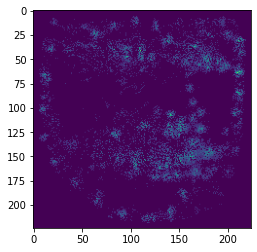

In [37]:
plt.imshow(reshape_pred[0,:,:].detach().numpy())

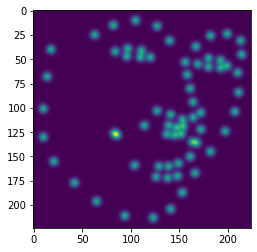

In [38]:
plt.imshow(reshape_label[0,:,:].detach().numpy())

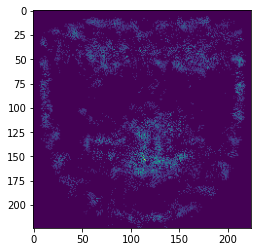

In [39]:
plt.imshow(reshape_pred[1,:,:].detach().numpy())

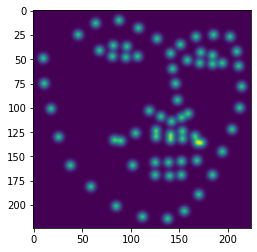

In [40]:
plt.imshow(reshape_label[1,:,:].detach().numpy())

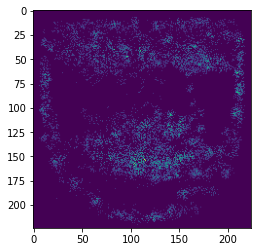

In [47]:
plt.imshow(reshape_pred[4,:,:].detach().numpy())

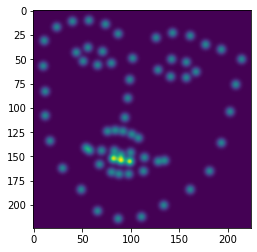

In [46]:
plt.imshow(reshape_label[4,:,:].detach().numpy())

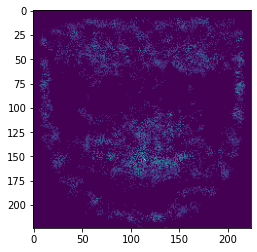

In [43]:
plt.imshow(reshape_pred[3,:,:].detach().numpy())

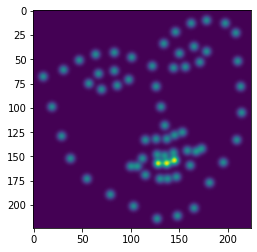

In [44]:
plt.imshow(reshape_label[3,:,:].detach().numpy())

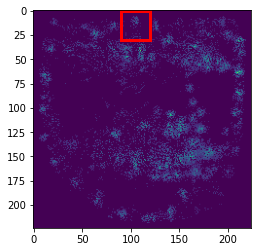

In [73]:
import matplotlib.patches as patches
plt.imshow(reshape_pred[0,:,:].detach().numpy())
currentAxis=plt.gca()
rect=patches.Rectangle((90, 0),30,30,linewidth=3,edgecolor='r',facecolor='none')
currentAxis.add_patch(rect)

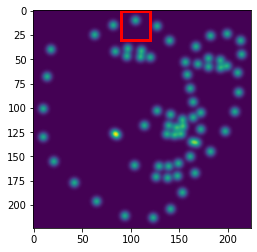

In [72]:
plt.imshow(reshape_label[0,:,:].detach().numpy())
currentAxis=plt.gca()
rect=patches.Rectangle((90, 0),30,30,linewidth=3,edgecolor='r',facecolor='none')
currentAxis.add_patch(rect)

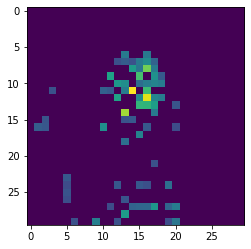

In [62]:
plt.imshow(reshape_pred[0,0:30,90:120].cpu().detach().numpy())

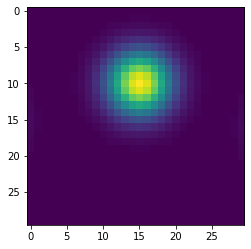

In [61]:
plt.imshow(reshape_label[0,0:30,90:120].cpu())

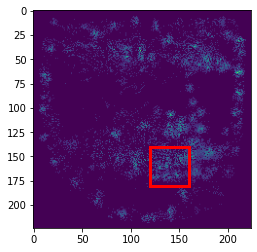

In [71]:
plt.imshow(reshape_pred[0,:,:].detach().numpy())
currentAxis=plt.gca()
rect=patches.Rectangle((120, 140),40,40,linewidth=3,edgecolor='r',facecolor='none')
currentAxis.add_patch(rect)

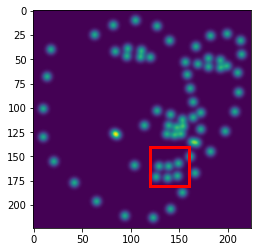

In [70]:
plt.imshow(reshape_label[0,:,:].detach().numpy())
currentAxis=plt.gca()
rect=patches.Rectangle((120, 140),40,40,linewidth=3,edgecolor='r',facecolor='none')
currentAxis.add_patch(rect)

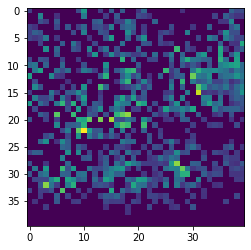

In [59]:
plt.imshow(reshape_pred[0,140:180,120:160].cpu().detach().numpy())

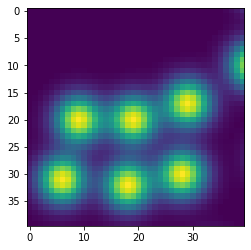

In [58]:
plt.imshow(reshape_label[0,140:180,120:160].cpu().detach().numpy())